# **BPR**: Bayesian Personalized Ranking from Implicit Feedback
This is an implementation of **MF-BPR** for MovieLens-100K dataset.


In [ ]:
!pip install livelossplot --quiet

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler, RandomSampler

from sklearn.metrics import roc_auc_score

from livelossplot import PlotLosses
from tqdm import tqdm

## **1.** Data Loader

### **a)** Get MovieLens-100K



In [ ]:
# Download MovieLens-100K.
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
df = pd.read_csv(url, sep='\t', names=["user", "item", "rating", "timestamp"])

# Convert rating to implicit feedback.
df['rating'] = (df['rating'] > 0).astype(int)

# Map index to each user, item.
user2idx = {user: idx for idx, user in enumerate(df['user'].unique())}
item2idx = {item: idx for idx, item in enumerate(df['item'].unique())}
df['user'] = df['user'].map(user2idx)
df['item'] = df['item'].map(item2idx)

# Construct interaction data.
user_item_interactions = list(zip(df['user'], df['item']))

### **b)** Train / Validation / Test

In [ ]:
# Train / Validation / Test
ratio = [0.6, 0.2, 0.2]

np.random.seed(42)
n = len(user_item_interactions)
train_size, val_size, test_size = [int(r * n) for r in ratio]

# Train
train_indices = np.random.choice(n, size=train_size, replace=False)
train_interactions = [user_item_interactions[i] for i in train_indices]

# Validation
remaining_indices = np.setdiff1d(np.arange(n), train_indices)
val_indices = np.random.choice(remaining_indices, size=val_size, replace=False)
val_interactions = [user_item_interactions[i] for i in val_indices]

# Test
test_indices = np.setdiff1d(remaining_indices, val_indices)
test_interactions = [user_item_interactions[i] for i in test_indices]

### **c)** Pair-wise Dataset with Bootstrap negative sampling

In [ ]:
class BPRDataset(Dataset):
    def __init__(self, user_item_interactions, num_users, num_items):
        self.user_item_interactions = user_item_interactions
        self.num_users = num_users
        self.num_items = num_items
        self.user_interactions = self._build_user_interactions()

    def _build_user_interactions(self):
        user_interactions = {}
        for user, item in self.user_item_interactions:
            if user not in user_interactions:
                user_interactions[user] = set()
            user_interactions[user].add(item)
        return user_interactions

    def __len__(self):
        return len(self.user_item_interactions)

    def __getitem__(self, idx):
        # Negative sampling
        user, pos_item = self.user_item_interactions[idx]
        neg_item = np.random.randint(self.num_items)
        while neg_item in self.user_interactions[user]:
            neg_item = np.random.randint(self.num_items)
        return user, pos_item, neg_item

In [ ]:
# Pair-wise dataset.
num_users = len(user2idx)
num_items = len(item2idx)

train_dataset = BPRDataset(train_interactions, num_users, num_items)
val_dataset = BPRDataset(val_interactions, num_users, num_items)
test_dataset = BPRDataset(test_interactions, num_users, num_items)

# Create the bootstrap sampler for training.
bootstrap_sampler = RandomSampler(data_source=train_dataset, replacement=True)

# Create the DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=1024, sampler=bootstrap_sampler)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## **2.** Model

### **a)** Matrix Factorization

In [ ]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim):
        super(MF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.item_embedding = nn.Embedding(num_items, embed_dim)
        self.user_embedding.weight.data.normal_(0, 0.1)
        self.item_embedding.weight.data.normal_(0, 0.1)

    def forward(self, user, item_i, item_j):
        user_emb = self.user_embedding(user)
        item_i_emb = self.item_embedding(item_i)
        item_j_emb = self.item_embedding(item_j)

        x_ui = (user_emb * item_i_emb).sum(dim=-1)
        x_uj = (user_emb * item_j_emb).sum(dim=-1)

        return x_ui, x_uj

### **b)** BPR Loss

It is equivalent to Negative $\textbf{BPR-OPT}.$  
i.e. **`bpr_loss`** is an implementation of $\sum_{(u,i,j) \in D_S}-\ln \sigma(\hat x_{uij})+\lambda_\Theta \| \Theta \|^2$

> **Note**: L2-regularization term is **`weight_decay`** of optimizer.

In [ ]:
def bpr_loss(x):
    loss = -torch.mean(torch.log(torch.sigmoid(x)))
    return loss

### **c)** Learning Algorithm

In [ ]:
def train_bpr(model, optimizer, train_loader, val_loader, num_epochs=10):
    groups = {'AUC': ['auc', 'val_auc'], 'BPR-Loss': ['loss', 'val_loss']}
    liveloss = PlotLosses(groups=groups, from_step=0)

    for epoch in range(num_epochs):
        print(f'\nEpoch #{epoch}')
        model.train()

        train_loss = val_loss   = 0
        y_labels = []  # Ground Truth
        y_scores = []  # Prediction

        for user, pos_item, neg_item in tqdm(train_loader):
            user = user.long()
            pos_item = pos_item.long()
            neg_item = neg_item.long()

            x_ui, x_uj = model(user, pos_item, neg_item)
            loss = bpr_loss(x_ui - x_uj)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate `train_auc`
            y_labels.extend([1] * len(x_ui))
            y_labels.extend([0] * len(x_uj))
            y_scores.extend(torch.sigmoid(x_ui).cpu().detach().numpy())
            y_scores.extend(torch.sigmoid(x_uj).cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_auc = roc_auc_score(y_labels, y_scores)
        val_loss, val_auc = evaluate(model, val_loader)

        history = {
            'auc': train_auc,
            'val_auc': val_auc,
            'loss': train_loss,
            'val_loss': val_loss
        }
        liveloss.update(history)
        liveloss.send()

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    loss_sum = 0
    y_labels = []  # Ground Truth
    y_scores = []  # Prediction

    with torch.no_grad():
        for user, pos_item, neg_item in dataloader:
            user = user.long()
            pos_item = pos_item.long()
            neg_item = neg_item.long()

            x_ui, x_uj = model(user, pos_item, neg_item)
            loss_sum += bpr_loss(x_ui - x_uj).item()

            # Calculate AUC
            y_scores.extend(torch.sigmoid(x_ui).cpu().numpy())
            y_scores.extend(torch.sigmoid(x_uj).cpu().numpy())
            y_labels.extend([1] * len(x_ui))
            y_labels.extend([0] * len(x_uj))

    loss = loss_sum / len(dataloader)
    auc = roc_auc_score(y_labels, y_scores)
    return loss, auc

In [ ]:
model = MF(num_users, num_items, embed_dim=32)
optimizer = {
    'Adam': optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001),
    'AdamW': optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001),
    'SGD' : optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)
}

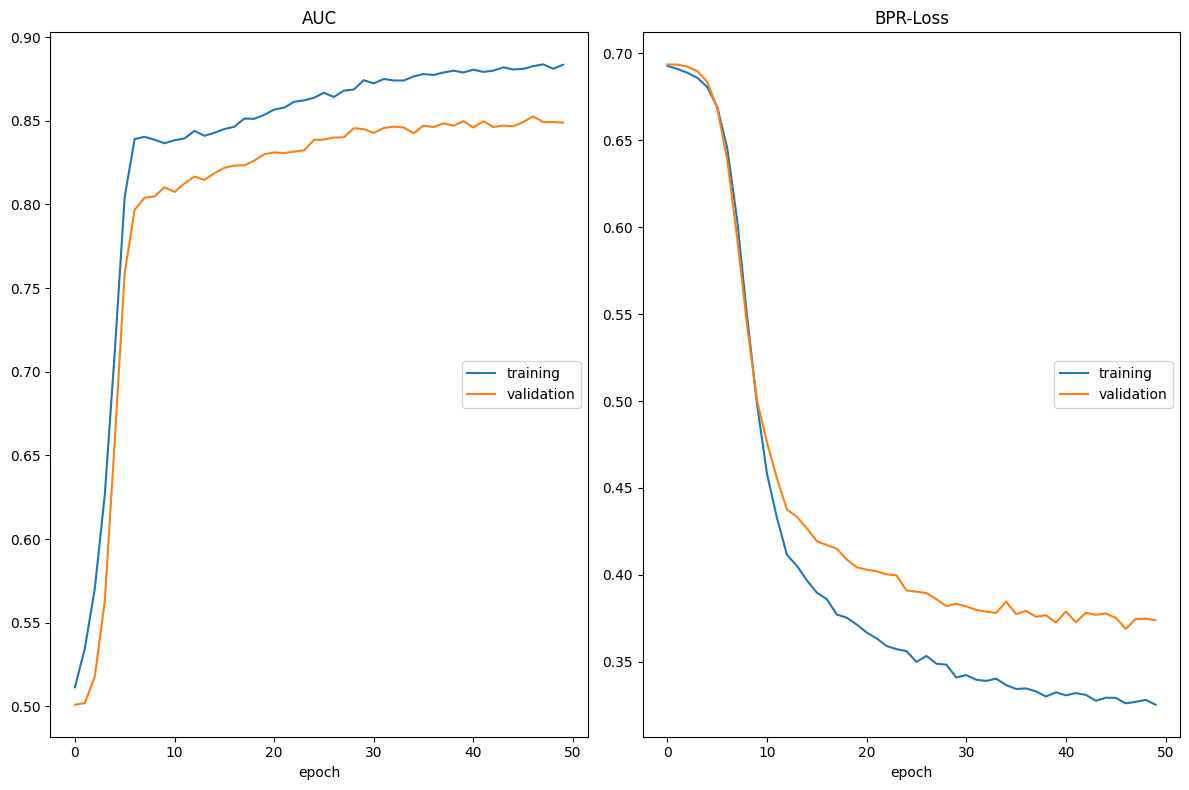

AUC
	training         	 (min:    0.511, max:    0.884, cur:    0.884)
	validation       	 (min:    0.501, max:    0.853, cur:    0.849)
BPR-Loss
	training         	 (min:    0.325, max:    0.693, cur:    0.325)
	validation       	 (min:    0.369, max:    0.694, cur:    0.374)

Test Loss: 0.373189651966095, Test AUC: 0.8496977325


In [ ]:
train_bpr(model, optimizer['Adam'], train_loader, val_loader, num_epochs=50)

loss, auc = evaluate(model, test_loader)
print(f'\nTest Loss: {loss}, Test AUC: {auc}')